## PART 2: Movie reviews

In [11]:
# Data manipulation and linear algebra
import scipy as sp  # Assuming scipy wasn't imported before

# Machine learning libraries and modules
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering and spatial distance
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance

# Visualization settings for Jupyter notebooks
%matplotlib inline


In [2]:
users = pd.read_csv("data/Movie/users.csv")
movies = pd.read_csv("data/Movie/movies.csv")
ratings_df = pd.read_csv("data/Movie/train.csv")

In [5]:
# Splitting the DataFrame into training and validation sets
train_df, validation_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

train_df.to_csv("data/Movie/train-train.csv")
validation_df.to_csv("data/Movie/train-validation.csv")

In [6]:
class dataset:
    def __init__(self, length, width, ratings_file_path):
        self.matrix = sp.sparse.lil_matrix((length + 1 , width + 1), dtype=int)
        self.build_matrix(ratings_file_path)
    
    def build_matrix(self, ratings_file_path):
        df = pd.read_csv(ratings_file_path)
        for row in df.itertuples():
            if row.rating > 3: 
                self.matrix[row.uID, row.mID] = row.rating
    
    def get_matrix(self):
        return self.matrix
        
        
datasetMat = dataset(users.uID.max(), movies.mID.max(), "C:/Users/jjzd8/data/train-train.csv")
movie_data_set = datasetMat.get_matrix()
movie_data_set

<6041x3953 sparse matrix of type '<class 'numpy.int32'>'
	with 322030 stored elements in List of Lists format>

In [7]:
TSVD = TruncatedSVD(n_components=50)
loadings = TSVD.fit_transform(movie_data_set) # user embeddings

## Visualize the movie domain

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6041 samples in 0.001s...
[t-SNE] Computed neighbors for 6041 samples in 0.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6041
[t-SNE] Computed conditional probabilities for sample 2000 / 6041
[t-SNE] Computed conditional probabilities for sample 3000 / 6041
[t-SNE] Computed conditional probabilities for sample 4000 / 6041
[t-SNE] Computed conditional probabilities for sample 5000 / 6041
[t-SNE] Computed conditional probabilities for sample 6000 / 6041
[t-SNE] Computed conditional probabilities for sample 6041 / 6041
[t-SNE] Mean sigma: 2.747676
[t-SNE] KL divergence after 50 iterations with early exaggeration: 83.439423
[t-SNE] KL divergence after 300 iterations: 2.671419


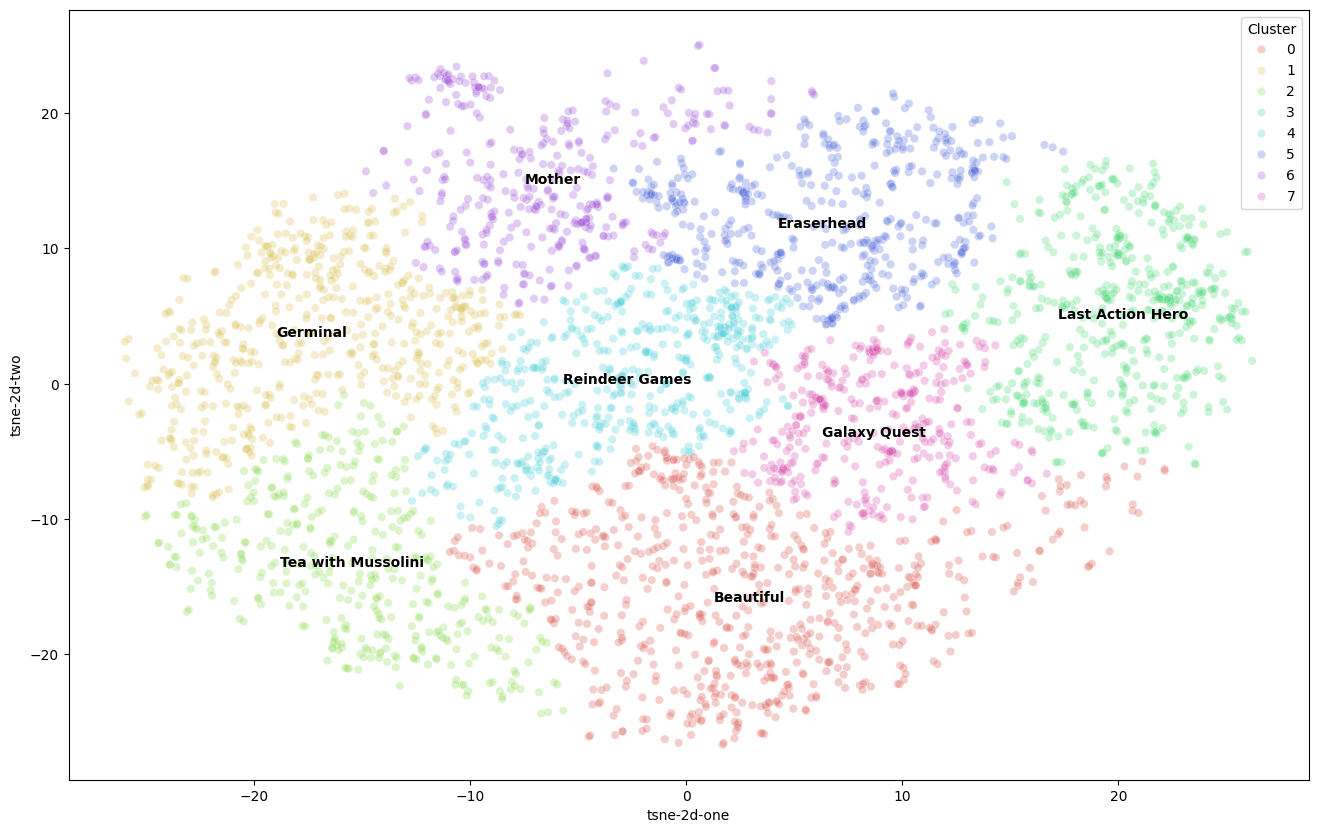

In [12]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300,  init="random")
tsne_results = tsne.fit_transform(loadings)

df = pd.DataFrame()
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]



AC = AgglomerativeClustering(n_clusters=8, linkage='ward')
AC_results = AC.fit(df)

df = df.join(movies.set_index('mID').title)
df['Cluster'] = AC_results.labels_
df.dropna(subset=['title'], inplace=True)

# Step 1: Calculate Centroids
centroids = df.groupby('Cluster')[['tsne-2d-one', 'tsne-2d-two']].mean().reset_index()

# Step 2: Find Closest Points to Centroids
# closest_points = pd.DataFrame(columns=['Cluster', 'Closest_Index'])
closest_points = []
for index, row in centroids.iterrows():
    cluster_points = df[df['Cluster'] == row['Cluster']]
    distances = np.sqrt((cluster_points['tsne-2d-one'] - row['tsne-2d-one'])**2 + (cluster_points['tsne-2d-two'] - row['tsne-2d-two'])**2)
    closest_point_index = distances.idxmin()
    closest_points.append({'Cluster': row['Cluster'], 'Closest_Index': closest_point_index})

closest_points= pd.DataFrame(closest_points)
# Step 3: Plot t-SNE and Label Closest Points
plt.figure(figsize=(16, 10))
scatter = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 8),
    hue='Cluster',
    data=df,
    legend="full",
    alpha=0.3
)

# Iterate over closest points to annotate them on the plot
for index, row in closest_points.iterrows():
    point = df.loc[row['Closest_Index']]
    plt.text(point['tsne-2d-one'], point['tsne-2d-two'], point['title'], 
             horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='semibold')

plt.show()

In the realm of collaborative filtering, dimensionality reduction plays a pivotal role in understanding and predicting user preferences within a complex movie recommendation landscape. By employing truncated Singular Value Decomposition (SVD), we facilitate a sophisticated mapping of users and movies onto a lower-dimensional latent space, enabling a nuanced interpretation of their interactions. This approach not only simplifies the user-movie matrix but also preserves essential relational patterns, thereby offering a robust foundation for subsequent analyses.

To quantify the affinity between user preferences and movie characteristics within this latent space, we have selected the cosine similarity metric, a choice inspired by its widespread application in document classification and information retrieval. Unlike Euclidean distance, which measures the magnitude of difference, cosine similarity evaluates the orientation of vectors representing users and movies. Consequently, it captures the degree of alignment in preferences and attributes, with closer angular proximity indicating greater similarity. This methodological choice underscores our commitment to a more intuitive and relevant measure of similarity in the context of movie recommendations.

In [13]:
class Predictor:
    def __init__(self, user_embeddings, movie_embeddings):
        self.user_embeddings = user_embeddings
        self.movie_embeddings = movie_embeddings
        
    def get_user_embedding(self, uID):
        return self.user_embeddings[uID]
    
    def get_movie_embedding(self, mID):
        return self.movie_embeddings[mID]
    
    def get_distance(self, array1, array2):
        return distance.cosine(array1, array2)
    
    def get_distance_from_ids(self, uID, mID):
        user_embedding = self.get_user_embedding(uID)
        movie_embedding = self.get_movie_embedding(mID)
        return self.get_distance(user_embedding, movie_embedding)
    
    def get_prediction(self, uID, mID):
        user_embedding = self.get_user_embedding(uID)
        movie_embedding = self.get_movie_embedding(mID)
        distance = self.get_distance(user_embedding, movie_embedding)
        if distance > 0.871: # (see below: finding the separator)
            return 2
        else:
            return 4 
        
prediction = Predictor(loadings, TSVD.components_.T)


In [14]:
data = []
for row in validation_df.itertuples():
    dist = prediction.get_distance_from_ids(row.uID, row.mID)
    data.append({'rating': row.rating, 'distance': dist})
    
ratings_vs_distance = pd.DataFrame(data)
ratings_vs_distance.groupby('rating')['distance'].median()

C:\Users\jjzd8\anaconda3\envs\UML\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


rating
1    0.918658
2    0.889308
3    0.858764
4    0.833815
5    0.831651
Name: distance, dtype: float64

## Finding the separator

To refine user movie preferences, we employ a decision stump, a simplistic model, to discern the pivotal distance that segregates liked from disliked movies. This model singularly evaluates the spatial disparity between a user's preference vector and a movie's feature vector within the latent space. By pinpointing this optimal distance threshold, the stump establishes a straightforward, binary criterion. This criterion is instrumental in predicting a movie's reception—liked or disliked—based on its relative proximity to the user's established preferences. Consequently, this approach enhances the model's predictive accuracy, ensuring recommendations are closely aligned with individual user tastes, thereby streamlining the recommendation process.

In [15]:
ratings_vs_distance['class'] = np.where(ratings_vs_distance['rating'] < 3, '<3', '>=3')
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(ratings_vs_distance['distance'].values.reshape(-1, 1), ratings_vs_distance['class'])
# Get the tree structure
tree = dt_classifier.tree_

# The root node (first split)
feature_index = tree.feature[0]  # Index of the feature used for the first split
threshold = tree.threshold[0]    # Threshold used for the first split

print(f"Threshold for the first split: {threshold}")

Threshold for the first split: 0.871437281370163


## Getting RMSE score

In [17]:
test_df = pd.read_csv("data/Movie/test.csv")
test_predictions = []
for row in test_df.itertuples():
    test_predictions.append(prediction.get_prediction(row.uID, row.mID))

# Calculate Mean Squared Error
mse = mean_squared_error(test_df.rating, test_predictions)

# Calculate Root Mean Squared Error
print(f'RMSE: {np.sqrt(mse)}')

C:\Users\jjzd8\anaconda3\envs\UML\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


RMSE: 1.464389406898421


## Discussion

The model's ability to predict ratings within a 1.5-point margin, while notable, does not match the effectiveness of simpler methods used in prior analyses. This shortfall is attributed to an oversimplified representation of user preferences in the dimensional space, failing to capture the complex tastes of movie viewers.

To improve accuracy, a key step is to refine the number of latent dimensions. Initial tests with 100 components did not achieve the desired differentiation between liked and disliked movies, indicating a need for an optimal dimensionality that better represents user preferences.

We propose a refined approach that utilizes the distances between movies and user preferences to predict a wider range of rating scores. By defining intervals for these distances, each aligned with specific rating levels from 1 to 5, we can achieve a more nuanced prediction that better captures the spectrum of user preferences.

Additionally, employing supervised learning algorithms to directly model user preferences from latent features may provide a more accurate prediction method. By leveraging the detailed information in the loadings, these algorithms could more closely align recommendations with individual user tastes.